# Preperations

In [1]:
import os, sys
sys.path.append('C:\\Users\\matthias\\Documents\\myProjects\\TU_Bibliothek\\code\\baseline-extract')
from src.data.dataset_line_rider import DatasetLineRider
from src.utils.normalize_baselines import *

import torch
import numpy as np

In [2]:
def compute_start_and_angle(baseline, idx):
    if torch.abs(baseline[idx, 0] - baseline[idx + 1, 0]) < 0.001:
        angle = torch.tensor(math.pi / 2.0).to(self.device)
    else:
        angle = torch.atan((baseline[idx, 1] - baseline[idx + 1, 1]) / (baseline[idx, 0] - baseline[idx + 1, 0]))
    # TODO: ^ make sure that the angle doesn't flip for vertical baselines

    x = baseline[idx, 0]
    y = baseline[idx, 1]

    return x, y, angle

In [3]:
parameters = {"input_folder": '..\\data\\cBAD-ICDAR2019', "max_side": 1000}

In [4]:
shuffle = {'train': False, 'eval': False}
batch_size_dict = {'train': 1, 'eval': 1}

image_datasets = {inf_type: DatasetLineRider(inf_type=inf_type,
                                            parameters=parameters)
                  for inf_type in ['train', 'eval']}

dataloaders = {inf_type: torch.utils.data.DataLoader(image_datasets[inf_type],
                                                     batch_size=batch_size_dict[inf_type],
                                                     shuffle=shuffle[inf_type],
                                                     num_workers=4)
               for inf_type in ['train', 'eval']}

In [5]:
d0 = image_datasets['train'][0]

In [6]:
bl_lengths = d0['bl_lengths']

In [7]:
import torchvision
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


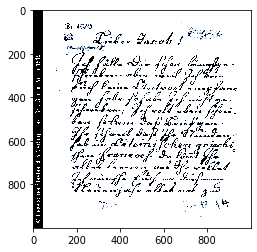

In [8]:
plt.imshow(d0['image'].permute(1,2,0).numpy())

In [9]:
#batch = next(iter(dataloaders['train']))

In [10]:
n = 4

In [11]:
box_size = 64
bl = d0['baselines'][n][:bl_lengths[n]]
bl_n = normalize_baselines(bl, box_size, device='cpu')
my_bl = bl_n
baselines_n = [normalize_baselines(b[:bl_lengths[n]], box_size, device='cpu') for n, b in enumerate(d0['baselines'][0:21])]

In [12]:
input_t = d0['image'].unsqueeze(0)

In [13]:
step = 0

In [14]:
size_par = 32

In [15]:
x_0, y_0, angle = compute_start_and_angle(bl_n, 0)


img_w = input_t.size(3)
img_h = input_t.size(2)

w_box_ratio = box_size/img_w
h_box_ratio = box_size/img_h

# grid_sample expects grid coordinates scaled to [-1,1]. This means that (-1,-1) is the top left corner and
# (1,1) is the bottom right corner.
w_box = box_size/img_w*2
h_box = box_size/img_h*2
x_scaled = x_0/img_w*2
y_scaled = y_0/img_h*2

alpha = angle
x_s = -1.0+x_scaled+np.cos(angle)*w_box/2
y_s = -1.0+y_scaled-np.sin(angle)*w_box/2
scale_x = w_box_ratio
scale_y = h_box_ratio
theta = torch.tensor([[scale_x*np.cos(alpha), -scale_x*np.sin(alpha), x_s],[scale_y*np.sin(alpha), scale_y*np.cos(alpha), y_s]]).unsqueeze(0).float()
size = (1, 3, size_par, size_par) #input_t.shape


agrid = torch.nn.functional.affine_grid(theta, size, align_corners=None)
grid_out = torch.nn.functional.grid_sample(input_t, agrid, mode='bilinear', padding_mode='zeros', align_corners=None)

c:\users\matthias\documents\myprojects\tu_bibliothek\code\baseline-extract\venv\lib\site-packages\torch\nn\functional.py:2751: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
c:\users\matthias\documents\myprojects\tu_bibliothek\code\baseline-extract\venv\lib\site-packages\torch\nn\functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


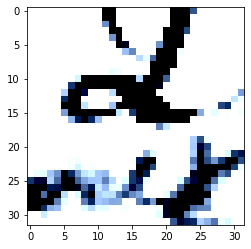

In [16]:
grid_image = grid_out[0].permute(1,2,0).numpy()
plt.imshow(grid_image)

# Plot baselines

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


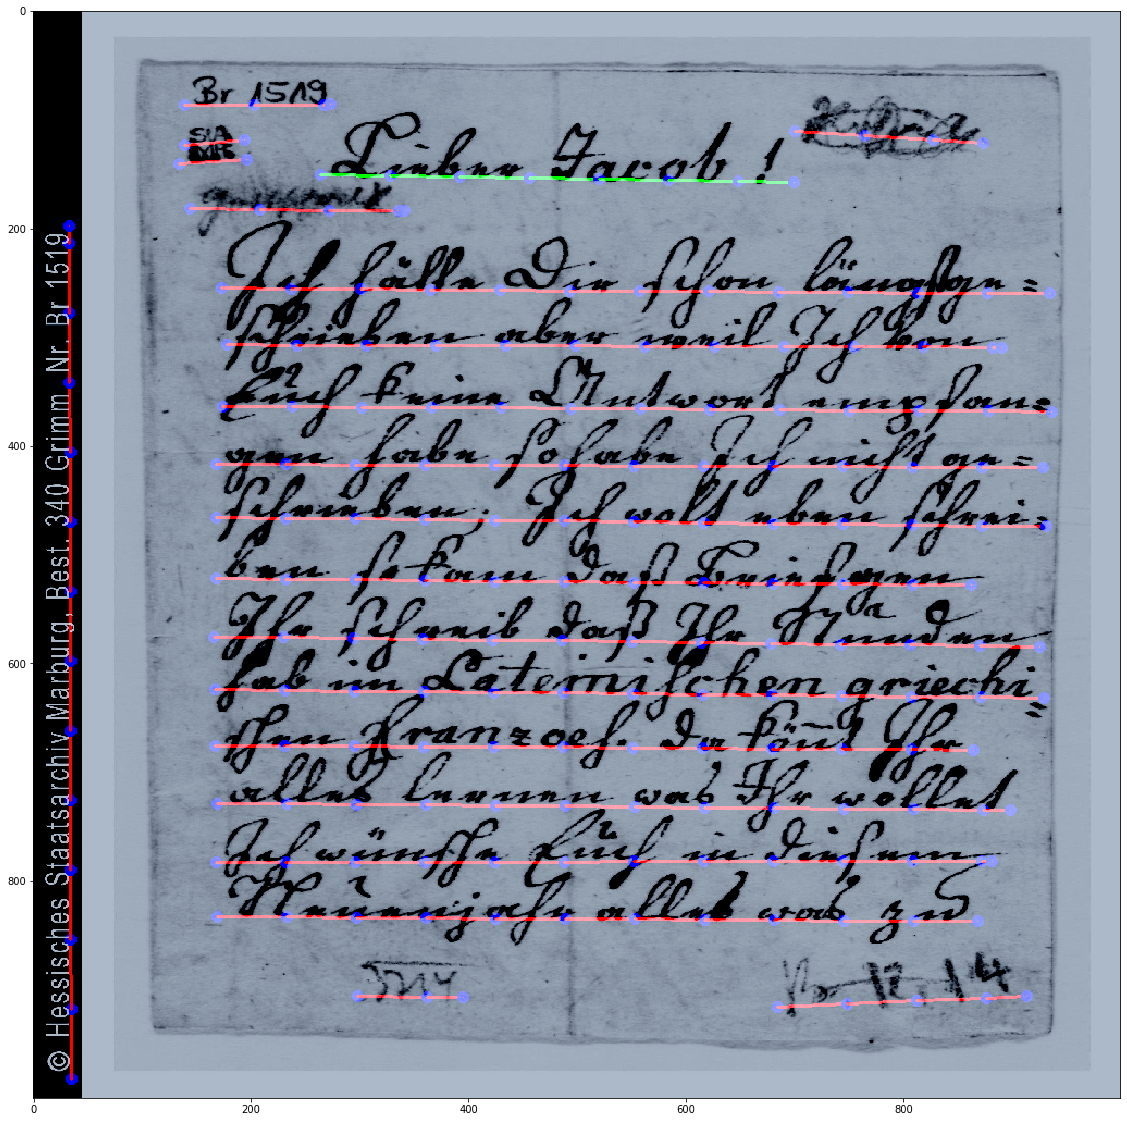

In [17]:
import cv2
#img_cv2 = cv2.imread('colors.jpg')#
img_cv1 = d0['image'].permute(1,2,0).numpy()
img_cv2 = np.zeros((1000,1000,3), dtype=np.float32)

for N, bl in enumerate(baselines_n):
    for k, p in enumerate(bl):
        if k == 0:
            p_list = p#.get_as_list()
            coords = (int(p_list[0]), int(p_list[1]))
            c_last = coords
            
            cv2.circle(img_cv2, coords, 3, (0,0,255), thickness=3)
            continue
        else:
            p_list = p#.get_as_list()
            coords = (int(p_list[0]), int(p_list[1]))
            if N == n:
                cv2.line(img_cv2, c_last, coords, (0,255,0), thickness=2)
            else:
                cv2.line(img_cv2, c_last, coords, (255,0,0), thickness=2)
                
            cv2.circle(img_cv2, coords, 3, (0,0,255), thickness=3)
            c_last = coords
            
            
comb = cv2.addWeighted(img_cv2,1.0,img_cv1,0.3,0)
plt.figure(figsize = (20,20))
plt.imshow(comb)

# Apply LineRider

In [277]:
from collections import OrderedDict
import torchvision
import torch
import torch.nn as nn


class LineRider(nn.Module):
    """
    A neural network that computes the baseline given the starting point, a scale parameter and an
    orientation parameter. It does this incrementally by applying a CNN to a rescaled image patch of a box around
    the last point. The box size is dependent on the letter size and needs to be given to the network as a parameter.
    The box is then resized to input_size x input_size.
    TLDR: input_size = number of pixels in width and height of the image patch that gets fed to the CNN
          box_size = size of the window that gets extracted (receptive field)
    """

    def __init__(self, device: str, input_size: int = 32):
        super(LineRider, self).__init__()
        self.device = device
        self.input_size = input_size
        self.lin = nn.Linear(2,2)
        self.lin2 = nn.Linear(2,2)

        self.rider = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5, stride=2)),
            ('relu1', nn.ReLU()),
            ('conv2', nn.Conv2d(in_channels=5, out_channels=10, kernel_size=5, stride=1)),
            ('relu2', nn.ReLU()),
            ('maxPool', nn.MaxPool2d(kernel_size=3, stride=2)),
            ('conv3', nn.Conv2d(in_channels=10, out_channels=15, kernel_size=4, stride=1)),
            ('relu3', nn.ReLU()),
            ('conv4', nn.Conv2d(in_channels=15, out_channels=2, kernel_size=1, stride=1))
            #TODO: ^ to 3 output channels for: baseline end, baseline length (only relevant if baseline end) and angle
        ]))

    def _rider(self, x):
        out = self.rider(x)[0, :, 0, 0]

        bl_end = nn.functional.sigmoid(out[0])
        bl_angle = nn.Tanh()(out[1])*1.5708 #pi/2

        return torch.stack([bl_end, bl_angle])

    def forward(self, img, x_0, y_0, angle, box_size):

        angle = angle#+self.lala+self.lala2+self.lala3
        x = x_0
        y = y_0
        
        linout = self.lin2(torch.stack([x,y]))
        x = linout[0]
        y = linout[1]

        x_list = x.clone().unsqueeze(0)
        y_list = y.clone().unsqueeze(0)

        img_w = img.size(2)
        img_h = img.size(3)

        w_box_ratio = box_size / img_w
        h_box_ratio = box_size / img_h

        # The size of the windows:
        size = (1, 3, self.input_size, self.input_size)

        # grid_sample expects grid coordinates scaled to [-1,1]. This means that (-1,-1) is the top left corner and
        # (1,1) is the bottom right corner.
        w_box = box_size / img_w * 2
        h_box = box_size / img_h * 2

        # Distinguishing between scale_x and scale_y is actually not necessary for squared images
        # I just left it in there in case i drop the resize to square
        scale_x = w_box_ratio
        scale_y = h_box_ratio

        baseline_end = 0

        #TODO: delete
        counter = 0

        for _ in range(int(img_w / box_size) + 5):
            alpha = -angle

            linout = self.lin(torch.stack([x,y]))
            x = linout[0]
            y = linout[1]
            
            # grid_sample expects grid coordinates scaled to [-1,1]. This means that (-1,-1) is the top left corner and
            # (1,1) is the bottom right corner.
            x_scaled = x / img_w * 2
            y_scaled = y / img_h * 2
            
            # The window is taken from the middle of the image:
            # o Move the top left corner with - (1,1)
            # o Move to specified point with + (x_scaled, y_scaled)
            # o move such that the start point is in the middle of the right border with
            #   + (cos(angle) * w_box, -sin(angle) * w_box)
            # // This assumes that the image is squared, otherwise the hypotenuse is not exactly w_box/2
            x_s = -1.0 + x_scaled + torch.cos(angle) * w_box / 2
            y_s = -1.0 + y_scaled - torch.sin(angle) * w_box / 2

            # Theta describes an affine transformation and has the form
            # ( A_11, A_12, x_s)
            # ( A_21. A_22. y_s)
            # where A is the product of a rotation matrix and a scaling matrix and x_s, y_s describe the translation.
            theta = torch.tensor([[scale_x * torch.cos(alpha), -scale_x * torch.sin(alpha), x_s],
                                  [scale_y * torch.sin(alpha), scale_y * torch.cos(alpha), y_s]]).unsqueeze(0).float()

            agrid = torch.nn.functional.affine_grid(theta, size).to(self.device)
            img_patch = torch.nn.functional.grid_sample(img, agrid, mode='nearest', padding_mode='zeros')

            out = self._rider(img_patch)
            # out = self.rider(img_patch)[0, :, 0, 0]

            baseline_end = out[0]
            angle = out[1]

            x = x + box_size * torch.cos(angle)
            y = y + box_size * torch.sin(angle)
            
            x_list = torch.cat([x_list, x.unsqueeze(0)], dim=0)
            y_list = torch.cat([y_list, y.unsqueeze(0)], dim=0)

            # TODO: delete
            counter += 1
            if counter > 4:
                break

            # if baseline_end < 0.5:
            #     break

        return torch.cat([x_list.unsqueeze(0), y_list.unsqueeze(0)], dim=0).permute(1, 0)


In [278]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lrider.rider.parameters(), lr=0.0004)

In [279]:
lrider = LineRider('cpu', 32)

In [280]:
#input_img = torch.tensor(grid_image).unsqueeze(0).permute(0,3,1,2)
#input_img.shape
#plt.imshow(grid_image)

In [281]:
sp = d0['start_points'][n]
sa = d0['start_angles'][n]

In [282]:
out = lrider(input_t, sp[0], sp[1], sa, 64)

k = 7
pred = out[0:5][0:k]
label = bl_n[0:k]

In [283]:
m = 1
optimizer.zero_grad()
loss = criterion(pred[m], label[m])
loss.backward(retain_graph=True)

In [284]:
print(' -- LIN -- ')
for p in lrider.lin.named_parameters():
    print(str(p[0]) + ': ' + str(torch.max(p[1])))
    
print('-'*20 + 'GRADIENTS' + '-'*20)
for p in lrider.lin.named_parameters():
    print(str(p[0]) + ': ' + str(p[1].grad))
    #print(str(p[0]) + ': ' + str(torch.max(p[1].grad)))

 -- LIN -- 
weight: tensor(0.1970, grad_fn=<MaxBackward1>)
bias: tensor(0.5325, grad_fn=<MaxBackward1>)
--------------------GRADIENTS--------------------
weight: tensor([[  26706.9141, -125018.7422],
        [  10360.3594,  -48498.2695]])
bias: tensor([-463.2557, -179.7099])


In [285]:
print(' -- LIN 2 --')
for p in lrider.lin2.named_parameters():
    print(str(p[0]) + ': ' + str(torch.max(p[1])))
    
print('-'*20 + 'GRADIENTS' + '-'*20)
for p in lrider.lin2.named_parameters():
    print(str(p[0]) + ': ' + str(p[1].grad))
    #print(str(p[0]) + ': ' + str(torch.max(p[1].grad)))

 -- LIN 2 --
weight: tensor(0.6742, grad_fn=<MaxBackward1>)
bias: tensor(0.2721, grad_fn=<MaxBackward1>)
--------------------GRADIENTS--------------------
weight: tensor([[60869.6445, 34946.5430],
        [74590.8828, 42824.1953]])
bias: tensor([230.3955, 282.3312])


In [225]:
for p in lrider.rider.named_parameters():
    print(str(p[0]) + ': ' + str(torch.max(p[1])))

conv1.weight: tensor(0.1154, grad_fn=<MaxBackward1>)
conv1.bias: tensor(0.0652, grad_fn=<MaxBackward1>)
conv2.weight: tensor(0.0893, grad_fn=<MaxBackward1>)
conv2.bias: tensor(0.0893, grad_fn=<MaxBackward1>)
conv3.weight: tensor(0.0790, grad_fn=<MaxBackward1>)
conv3.bias: tensor(0.0515, grad_fn=<MaxBackward1>)
conv4.weight: tensor(0.2544, grad_fn=<MaxBackward1>)
conv4.bias: tensor(0.1952, grad_fn=<MaxBackward1>)


In [226]:
for p in lrider.rider.named_parameters():
    print(str(p[0]) + ': ' + str(torch.max(p[1].grad)))

conv1.weight: tensor(7287.0215)
conv1.bias: tensor(1095.5828)
conv2.weight: tensor(3326.3979)
conv2.bias: tensor(3377.6758)
conv3.weight: tensor(4714.0117)
conv3.bias: tensor(8633.6553)
conv4.weight: tensor(28.4050)
conv4.bias: tensor(0.)


In [170]:
baselines_n[1]

tensor([[700.1925, 111.7647],
        [764.0752, 115.6381],
        [827.9579, 119.5115],
        [873.4360, 122.2689]])

In [163]:
sp = d0['start_points'][n]
sa = d0['start_angles'][n]

In [165]:
lrider(input_t, sp[0], sp[1], sa, 64)

## angle: tensor(-0.0345, grad_fn=<SelectBackward>)
## x:     tensor(264.1964)
## y:     tensor(151.6807)


(tensor([328.1583, 153.8877], grad_fn=<StackBackward>),
 tensor(-0.0345, grad_fn=<SelectBackward>))

In [46]:
_x, _y, _ilist = lrider(input_t, x_0, y_0, angle, 100)

In [46]:
nplist = [i.permute(0,2,3,1)[0].numpy() for i in _ilist]

In [56]:
import torchvision
import torch.nn as nn

In [43]:
model = torchvision.models.mnasnet1_0(pretrained=True)

Downloading: "https://download.pytorch.org/models/mnasnet1.0_top1_73.512-f206786ef8.pth" to C:\Users\matthias/.cache\torch\checkpoints\mnasnet1.0_top1_73.512-f206786ef8.pth
100%|██████████| 16.9M/16.9M [00:00<00:00, 18.3MB/s]


In [57]:
for m in model.modules():
  if isinstance(m, nn.BatchNorm2d):
    m.eval()

In [84]:
model.classifier = nn.Sequential(nn.Dropout(0.8), nn.Linear(in_features=1280, out_features=2))

In [85]:
model

MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(16, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(48, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


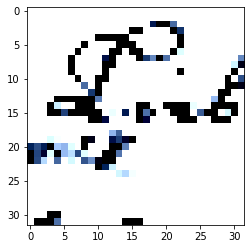

In [76]:
grid_image = grid_out[0].permute(1,2,0).numpy()
plt.imshow(grid_image)

In [78]:
grid_out.shape

torch.Size([1, 3, 32, 32])

In [90]:
model.eval()

MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(16, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(48, 

In [94]:
model(grid_out)

tensor([[ 0.1584, -0.0542]], grad_fn=<AddmmBackward>)

In [80]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [95]:
model.parameters

<bound method Module.parameters of MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(16, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inpla

In [81]:
model.classifier = Identity()

In [99]:
nn.Tanh()(torch.tensor(-0.6))

tensor(-0.5370)

In [103]:
nn.Softmax()(torch.tensor([0.999, 0.0011]))

c:\users\matthias\documents\myprojects\tu_bibliothek\code\baseline-extract\venv\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([0.7306, 0.2694])

In [108]:
x = torch.tensor(1.2)

In [109]:
x_list = x.clone().unsqueeze(0)

In [110]:
x_list

tensor([1.2000])

In [111]:
x.shape

torch.Size([])

In [112]:
x_list.shape

torch.Size([1])

In [107]:
torch.cat([x_list, x.unsqueeze(0)], dim=0)

tensor([1.2000, 1.2000])

In [113]:
x.device

device(type='cpu')

In [15]:
inp = d0['image']

In [27]:
#d0['baselines']

In [26]:
box_size = 128
bl = d0['baselines'][n][:bl_lengths[n]]
bl_n = normalize_baselines(bl, box_size, device='cpu')
my_bl = bl_n
baselines_n = [normalize_baselines(b[:bl_lengths[n]], box_size, device='cpu') for n, b in enumerate(d0['baselines'][0:21])]

In [27]:
number_of_baselines = min([idx for idx in range(0, len(bl_lengths)) if bl_lengths[idx] == -1])
baselines_n = [normalize_baselines(b[:bl_lengths[n]], box_size, device='cpu') for n, b in enumerate(d0['baselines'][0:21])]

In [28]:
# image is normed!!!!!!!!!!!!!!

In [79]:
def draw_baselines(image: torch.tensor, baselines: torch.tensor, bl_lengths: torch.tensor,
                   box_size: int, device: str, idx=-1):
    h = image.shape[1]
    w = image.shape[2]

    img_cv1 = image.permute(1, 2, 0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_cv1 = std * img_cv1 + mean
    img_cv1 = np.clip(img_cv1, 0, 1)
    
    img_cv2 = np.zeros((h, w, 3), dtype=np.float32)

    number_of_baselines = min([idx for idx in range(0, len(bl_lengths)) if bl_lengths[idx] == -1])
    baselines_n = [normalize_baselines(b[:bl_lengths[n]], box_size, device=device)
                   for n, b in enumerate(baselines[0:number_of_baselines])]

    for N, bl in enumerate(baselines_n):
        for k, p in enumerate(bl):
            if k == 0:
                coords = (int(p[0]), int(p[1]))
                c_last = coords

                cv2.circle(img_cv2, coords, 3, (0, 0, 1.0), thickness=3)
                continue
            else:
                coords = (int(p[0]), int(p[1]))
                if N == idx:
                    cv2.line(img_cv2, c_last, coords, (0, 1.0, 0), thickness=2)
                else:
                    cv2.line(img_cv2, c_last, coords, (1.0, 0, 0), thickness=2)

                cv2.circle(img_cv2, coords, 3, (0, 0, 1.0), thickness=3)
                c_last = coords

    img_cv2 = img_cv2.astype(np.float64)
    comb = cv2.addWeighted(img_cv2,0.7,img_cv1,0.3,0)
    #comb = cv2.cvtColor(comb, cv2.COLOR_BGR2RGB)
    comb = torchvision.transforms.ToTensor()(comb)

    return comb

In [80]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [81]:
bimg = draw_baselines(d0['image'], d0['baselines'], d0['bl_lengths'], box_size=box_size, device='cpu')

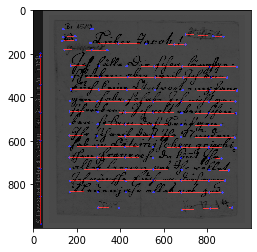

In [75]:
plt.imshow(bimg)

In [31]:
d0['image'].shape

torch.Size([3, 1000, 1000])

In [32]:
bimg.shape

(1000, 1000, 3)

In [33]:
cv2.imwrite('test.jpg', bimg)

True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


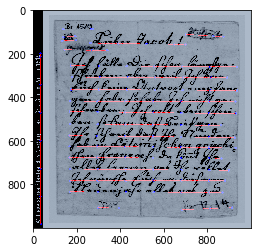

In [34]:
plt.imshow(bimg)

In [330]:
cv2.imwrite('test.jpg', bimg.numpy().transpose(1,2,0))

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

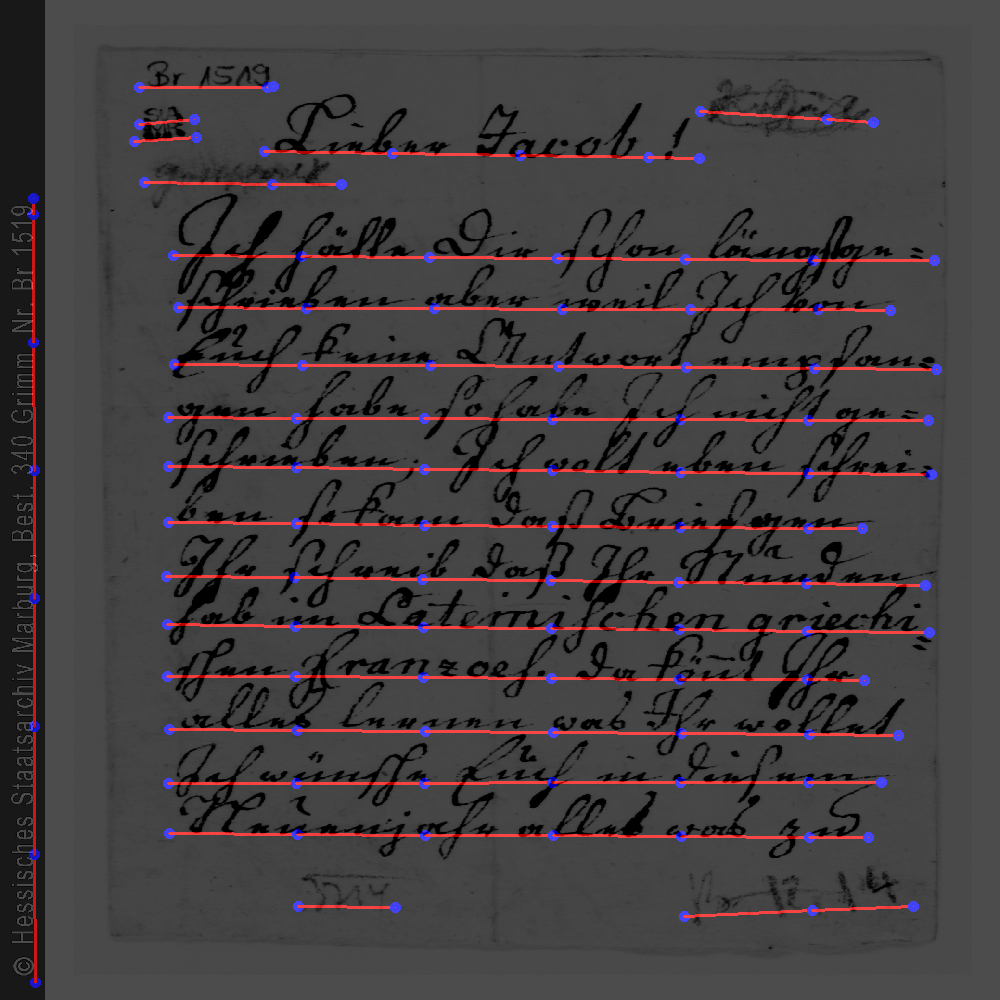

In [83]:
torchvision.transforms.ToPILImage()(bimg.float())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


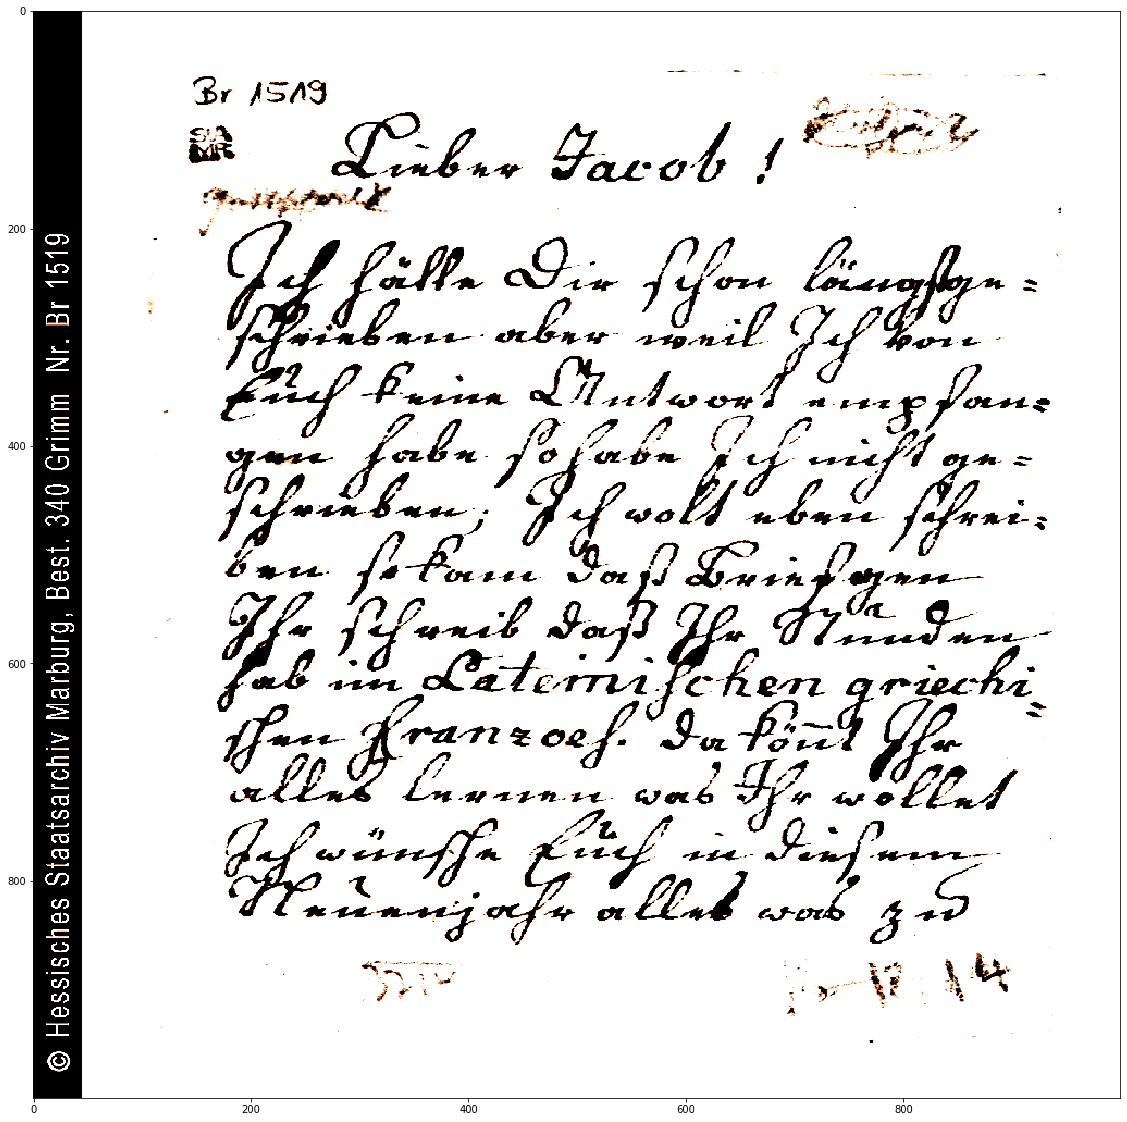

In [322]:
fig = plt.figure(figsize = (20,20))
plt.imshow(bimg)

In [84]:
import random

In [93]:
random.uniform(0,0.1)

0.06884158042884742

In [108]:
bl_n

tensor([[264.1964, 151.6807],
        [392.1791, 153.7820],
        [520.1619, 155.8834],
        [648.1447, 157.9848],
        [699.2300, 158.8235]])

In [105]:
x = torch.tensor([0]*len(bl_n)+[1]).float()
y = torch.tensor([0]*(len(bl_n)-1)+[1,0]).float()

In [121]:
x = torch.tensor([0,0,0,0,1]).float()
y = torch.tensor([1,0.5,0.5,1,1]).float()

In [122]:
torch.nn.BCELoss()(x,y)

tensor(16.5786)

In [125]:
#grid_image

In [151]:
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(in_features=512, out_features=3)
)

In [152]:
model(grid_out).shape

torch.Size([1, 3])

In [199]:
import torchvision
import torch
import torch.nn as nn


class LineFinder(nn.Module):

    def __init__(self):
        super(LineFinder, self).__init__()
        
        resnet = torchvision.models.resnet18(pretrained=True)

        for m in resnet.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()

        layer0 = nn.Sequential(
            resnet.conv1,
            resnet.relu,
            resnet.maxpool)
        layer1 = resnet.layer1
        layer2 = resnet.layer2
        layer3 = resnet.layer3
        layer4 = resnet.layer4
        
        # out_channels = 4:
        # 0: x
        # 1: y
        # 2: angle
        # 3: box_size
        self.model = nn.Sequential(
            layer0,
            layer1,
            layer2,
            layer3,
            layer4)
            #nn.Conv2d(in_channels=256, out_channels=4, kernel_size=1))

    def forward(self, x):
        return self.model(x)

In [200]:
lf = LineFinder()

In [201]:
input_t.shape

torch.Size([1, 3, 1000, 1000])

In [202]:
lf.model(input_t).shape

torch.Size([1, 512, 32, 32])

In [2]:
import torch

In [28]:
h = 6
w = 6
patch_size = 32.0
offset_tensor = torch.zeros(4, h, w)

In [29]:
for row in range(offset_tensor.shape[1]):
    for column in range(offset_tensor.shape[2]):
        offset_tensor[0, row, column] = patch_size/2.0 + row*patch_size
        offset_tensor[1, row, column] = patch_size/2.0 + column*patch_size

In [27]:
(offset_tensor+offset_tensor)[0,:,:]

tensor([[ 32.,  32.,  32.,  32.,  32.,  32.],
        [ 96.,  96.,  96.,  96.,  96.,  96.],
        [160., 160., 160., 160., 160., 160.],
        [224., 224., 224., 224., 224., 224.],
        [288., 288., 288., 288., 288., 288.],
        [352., 352., 352., 352., 352., 352.]])

In [24]:
offset_tensor[1,:,:]

tensor([[ 16.,  48.,  80., 112., 144., 176.],
        [ 16.,  48.,  80., 112., 144., 176.],
        [ 16.,  48.,  80., 112., 144., 176.],
        [ 16.,  48.,  80., 112., 144., 176.],
        [ 16.,  48.,  80., 112., 144., 176.],
        [ 16.,  48.,  80., 112., 144., 176.]])

In [25]:
offset_tensor[2,:,:]

tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])

In [26]:
offset_tensor[3,:,:]

tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])

In [30]:
offset_tensor

tensor([[[ 16.,  16.,  16.,  16.,  16.,  16.],
         [ 48.,  48.,  48.,  48.,  48.,  48.],
         [ 80.,  80.,  80.,  80.,  80.,  80.],
         [112., 112., 112., 112., 112., 112.],
         [144., 144., 144., 144., 144., 144.],
         [176., 176., 176., 176., 176., 176.]],

        [[ 16.,  48.,  80., 112., 144., 176.],
         [ 16.,  48.,  80., 112., 144., 176.],
         [ 16.,  48.,  80., 112., 144., 176.],
         [ 16.,  48.,  80., 112., 144., 176.],
         [ 16.,  48.,  80., 112., 144., 176.],
         [ 16.,  48.,  80., 112., 144., 176.]],

        [[  0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.]],

        [[  0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.],
       

In [31]:
import torch.nn as nn

In [33]:
affine_out = nn.Flatten()(offset_tensor)

In [42]:
label = torch.randint(low=0, high=150, size=(4,8))

In [172]:
from scipy.optimize import linear_sum_assignment

In [ ]:
linear_sum_assignment

In [20]:
bl_n

tensor([[264.1964, 151.6807],
        [328.1877, 152.7314],
        [392.1791, 153.7820],
        [456.1705, 154.8327],
        [520.1619, 155.8834],
        [584.1532, 156.9341],
        [648.1446, 157.9847],
        [699.2300, 158.8235]])

In [19]:
for x,y in bl_n:
    print(str(x) + ' ' + str(y))

tensor(264.1964) tensor(151.6807)
tensor(328.1877) tensor(152.7314)
tensor(392.1791) tensor(153.7820)
tensor(456.1705) tensor(154.8327)
tensor(520.1619) tensor(155.8834)
tensor(584.1532) tensor(156.9341)
tensor(648.1446) tensor(157.9847)
tensor(699.2300) tensor(158.8235)


In [21]:
for idx in range(2,5):
    print(idx)

2
3
4


In [23]:
x_n, y_n = bl_n[3]

In [24]:
print(str(x_n) + ' ' + str(y_n))

tensor(456.1705) tensor(154.8327)
